In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from turtle import speed

# change matplotlib backend to allow for interactive plots
%matplotlib ipympl
#%matplotlib notebook

In [2]:
class SimulationObject():

    def __init__(self, acc=(0,0,0), vel=(0,0,0), loc=(0,0,0), bounce_cor=1) -> None:
        self.acc = np.array(acc)
        self.vel = np.array(vel)
        self.loc = np.array(loc)
        self.bounce_cor = bounce_cor
        self.collision_counter = {}

    def update_vel(self, dt):
        self.vel =  self.acc * dt + self.vel
        return self.vel

    def update_loc(self, dt):
        self.loc = 0.5 * self.acc * np.power(dt,2) + self.vel * dt + self.loc
        return self.loc

    def update_without_collision(self, dt):
        self.update_vel(dt)
        self.update_loc(dt)
        return self

    def update(self, dt, obstacles={}):
        prev_vel = self.vel
        prev_loc = self.loc
        self.update_vel(dt)
        self.update_loc(dt)
        
        for key in list(set(obstacles) - set(self.collision_counter)): # match collision_counter dict with obstacles dict
            self.collision_counter[key] = 0

        if len(self.vel) == 2: # 2D

            for obstacle in obstacles: # naiv approach that only one obstacle can get hit
                obstacle_instance = obstacles[obstacle][0] # get obstacle instance out of obstacle tuple (obstacle_instance, color)
            
                intersection = self.solve_intersection(obstacle_instance.point_0, obstacle_instance.point_1, prev_loc, self.loc) # euler method linear

                if self.is_collision(intersection[1], intersection[2]):
                    self.collision_counter[obstacle] += 1
                    #print(str(obstacle) + " collision counter: " + str(self.collision_counter[obstacle]))
                    dt_collision = intersection[2] * dt # collision time
                    self.vel = prev_vel # reset
                    self.loc = prev_loc # reset
                    self.update_vel(dt_collision)
                    self.loc = intersection[0] # set location to collision point
                    #print("Loc of collision: " + str(self.loc))
                    #print("Vel of collision: " + str(self.vel))
                    #print("t1,t2: " + str((intersection[1], intersection[2])))
                    self.reflect_vel(obstacle_instance)
                    #print("Reflected Vel of collision: " + str(self.vel))
                    self.vel = self.vel * self.bounce_cor # bounce losses
                    #self.update_vel(dt-dt_collision)
                    #self.update_loc(dt-dt_collision)
                    self.update(dt-dt_collision, obstacles) # if it runs into problems tweak paramater in is_collision()

                    break # naiv approach only support single collision

        elif len(self.vel) == 3: # TODO 3D -> not working yet!

            for obstacle in obstacles: # naiv approach that only one obstacle can get hit
                obstacle_instance = obstacles[obstacle][0] # get obstacle instance out of obstacle tuple (obstacle_instance, color)

                # TODO intersection with time and point of intersection in 3D
                
                if self.is_collision(intersection[1], intersection[2]): # is collision
                    self.collision_counter[obstacle] += 1
                    dt_collision = intersection[2] * dt # collision time
                    self.vel = prev_vel # reset
                    self.loc = prev_loc # reset
                    self.update_vel(dt_collision)
                    self.loc = intersection[0]
                    self.reflect_vel(obstacle_instance) # TODO implement in 3D
                    self.vel = self.vel * self.bounce_cor # bounce losses
                    #self.update(dt-dt_collision, obstacles) # update with remaining time
                    break # naiv approach only support single collision

        else:
            print("Only 2 or 3 D cases supported!")

        return self

    def solve_intersection(self, a, b, c, d):
        # https://www.youtube.com/watch?v=5FkOO1Wwb8w&ab_channel=EngineerNick
        # https://replit.com/@thehappycheese/linetools#LineTools/line_tools.py
        # computes the intersection between two line segments; a to b, and c to d

        ab = b - a
        cd = d - c
        
        # The intersection of segments is expressed as a parametric equation
        # where t1 and t2 are unknown scalars 
        # note that a real intersection can only happen when 0<=t1<=1 and 0<=t2<=1,
        # a + ab·t1 = c + cd·t2
        
        # This can be rearranged as follows:
        # ab·t1 - cd·t2 = c - a
        
        # by collecting the scalars t1 and -t2 into the column vector T,
        # and by collecting the vectors ab and cd into matrix M:
        # we get the matrix form:
        # [ab_x  cd_x][ t1] = [ac_x]
        # [ab_y  cd_y][-t2]   [ac_y]
        # or
        # M·T=ac
        
        # the determinant of the matrix M is the inverse of the cross product of ab and cd.
        # 1/(ab×cd)
        # Therefore if ab×cd=0 the determinant is undefined and the matrix cannot be inverted
        # This means the lines are
        #   a) parallel and
        #   b) possibly collinear
        
        # pre-multiplying both sides by the inverted 2x2 matrix we get:
        # [ t1] = 1/(ab×cd)·[ cd_y  -cd_x][ac_x]
        # [-t2]             [-ab_y   ab_x][ac_y]
        # or
        # T = M⁻¹·ac
        
        # multiplied out
        # [ t1] = 1/(ab_x·cd_y - ab_y·cd_x)·[ cd_y·ac_x - cd_x·ac_y]
        # [-t2]                             [-ab_y·ac_x + ab_x·ac_y]
        
        # since it is neat to write cross products in python code, observe that the above is equivalent to:
        # [ t1] = [ ac×cd / ab×cd ]
        # [-t2] = [ ab×ac / ab×cd ]
        
        ab_cross_cd = np.cross(ab, cd)
        
        if ab_cross_cd == 0:
            
            # vectors are not linearly independent; ab and cd are parallel
            # segments are collinear if ac is parallel to ab
            # ac ∥ ab
            # or more conveniently if ac is perpendicular to the left normal of ab
            # ac ⟂ (ab⟂)
            # the left normal of ab = [-ab_y]
            #                         [ ab_x]
            # dot product of perpendicular vectors is zero:
            # if ab.left.dot(ac) == 0:
            # 	# segments are collinear
            # 	# TODO: we can compute the range over which t1 and t2 produce an overlap, if any, here. Doesnt seem to be needed for now.
            # else:
            # 	# segments are parallel
            # 	return None
            
            return (np.inf, np.inf, np.inf)
        else:
            ac = c - a
            t1 = np.cross(ac, cd) / ab_cross_cd
            t2 = -np.cross(ab, ac) / ab_cross_cd
            return (a + ab * t1, t1, t2) # point of intersection, t1, t2

    def is_collision(self, t1, t2):
        tweak_me = 1.e-10 # loc is on obstacle after collision, to not count it twice this has to be as close as possible to 0 but not 0 (see solve_intersection())
        return 0 <= t1 <= 1 and tweak_me < t2 <= 1

    def reflect_vel(self, obstacle_instance):
        obstacle = obstacle_instance.point_1 - obstacle_instance.point_0
        obstacle_orthogonal = np.array([obstacle[1], -obstacle[0]]) # in 2D [x,y] -> clockwise: [y,-x] / cclockwise: [-y,x]
        self.vel = self.vel - 2 * (np.dot(self.vel, obstacle_orthogonal))/(np.dot(obstacle_orthogonal, obstacle_orthogonal)) * obstacle_orthogonal # bounce = reflect velocity https://www.youtube.com/watch?v=naaeH1qbjdQ&ab_channel=TheCodingTrain

        return self.vel


In [3]:
class Obstacle():
    
    def __init__(self, point_0, point_1, point_2=0) -> None:
        self.point_0 = np.array(point_0)
        self.point_1 = np.array(point_1)
        self.point_2 = np.array(point_2) # optional for planes
        #self.orthogonal =  np.array()



In [4]:
fps = 200
dt = 1/fps
gravity = -9.81

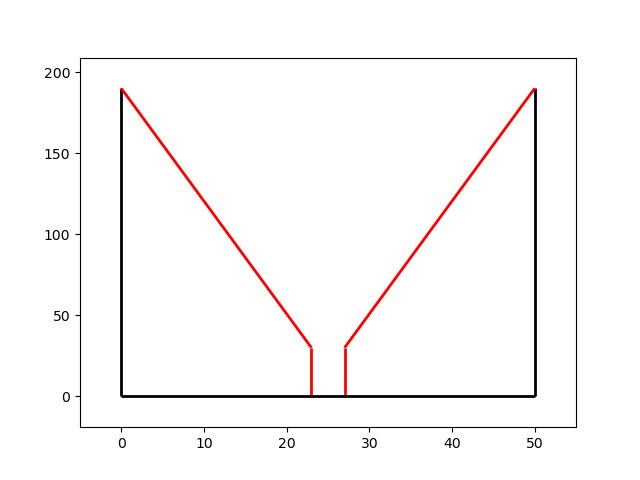

In [7]:
# 2D
loc_history = np.empty((2,0))

ball = SimulationObject(acc=(0,gravity), vel=(25,0), loc=(0,200), bounce_cor=0.9)

funnel_total_w = 50
funnel_total_h = 190
funnel_opening_w = 4
funnel_opening_h  = 30

obstacles = {
        # (obstacle instance, color)
        "left_limit" : (Obstacle((0,0), (0,funnel_total_h)), "k"),
        "right_limit" : (Obstacle((funnel_total_w,0), (funnel_total_w,funnel_total_h)), "k"),
        "left_ramp" : (Obstacle((0, funnel_total_h), (funnel_total_w/2 - funnel_opening_w/2, funnel_opening_h)), "r"),
        "right_ramp" : (Obstacle((funnel_total_w/2 + funnel_opening_w/2, funnel_opening_h), (funnel_total_w,funnel_total_h)), "r"), 
        "left funnel_opening" : (Obstacle((funnel_total_w/2 - funnel_opening_w/2, funnel_opening_h), (funnel_total_w/2 - funnel_opening_w/2, 0)), "r"),
        "right funnel_opening" : (Obstacle((funnel_total_w/2 + funnel_opening_w/2, funnel_opening_h), (funnel_total_w/2 + funnel_opening_w/2, 0)), "r"),
        "floor" : (Obstacle((0,0), (funnel_total_w,0)), "k"),
}

while(True): # do while loop
        ball.update(dt, obstacles=obstacles)
        loc_history = np.concatenate((loc_history, np.vstack(ball.loc)), axis=1) # ToDo understand concatenate axis better
        if (ball.collision_counter["floor"] == 1): break # condition for do while loop
            
#td_acc_history = np.arange(0, len(loc_history[1]))*dt # recreates time list
#plt.plot(td_acc_history, loc_history[1]) # plots curve over time not x

lines = [(obstacle_tuple[0].point_0, obstacle_tuple[0].point_1) for obstacle_tuple in list(obstacles.values())]
lc = mpl.collections.LineCollection(lines, colors=[obstacle_tuple[1] for obstacle_tuple in list(obstacles.values())], linewidths=2)
fig, ax = plt.subplots()
#ax.cla() # clear the previous image
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)
line, = ax.plot([]) # plot empty plot

def animate(i):
    line.set_data((loc_history[0][0:i], loc_history[1][0:i]))
    return ax

anim = FuncAnimation(fig, animate, frames=len(loc_history[0])+1, interval=dt*1000, repeat=False)
#anim.save('funnel2D_1_video.mp4', fps = fps, extra_args = ['-vcodec', 'libx264'])
plt.show()

In [6]:
# 3D -> TODO
loc_history = np.empty((3,0))

ball = SimulationObject(acc=(0,0,gravity), vel=(25,0,0), loc=(0,0,200), bounce_cor=0.9)

obstacles = {
        # (obstacle instance, color)
        "floor" : (Obstacle((0,0,0), (1,0,0), (0,1,0)), "k"),
}

while(True): # do while loop
        ball.update(dt, obstacles=obstacles)
        loc_history = np.concatenate((loc_history, np.vstack(ball.loc)), axis=1) # ToDo understand concatenate axis better
        if not (ball.collision_counter["floor"] == 0): break # condition for do while loop
            
fig, ax = plt.subplots(projection='3d')

# Create cubic bounding box to simulate equal aspect ratio, since matplotlib3d does not support aspect=equal
max_range = np.array([loc_history[0].max()-loc_history[0].min(), loc_history[1].max()-loc_history[1].min(), loc_history[2].max()-loc_history[2].min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(loc_history[0].max()+loc_history[0].min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(loc_history[1].max()+loc_history[1].min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(loc_history[2].max()+loc_history[2].min())

for xb, yb, zb in zip(Xb, Yb, Zb):
   ax.plot([xb], [yb], [zb], 'w')

plt.grid()
plt.show()

UnboundLocalError: local variable 'intersection' referenced before assignment

In [ ]:
np.ones((3,3))
#np.concatenate((np.ones((3,3)), np.vstack(np.ones((3,1)))), axis=1)

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [ ]:
#ToDo
# 3D
    # planes
    # polygons

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

scat = ax.plot3D(loc_history[0], loc_history[1] ,loc_history[2])

# Create cubic bounding box to simulate equal aspect ratio, since matplotlib3d does not support aspect=equal
max_range = np.array([loc_history[0].max()-loc_history[0].min(), loc_history[1].max()-loc_history[1].min(), loc_history[2].max()-loc_history[2].min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(loc_history[0].max()+loc_history[0].min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(loc_history[1].max()+loc_history[1].min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(loc_history[2].max()+loc_history[2].min())

for xb, yb, zb in zip(Xb, Yb, Zb):
   ax.plot([xb], [yb], [zb], 'w')

plt.grid()
plt.show()

"\nfig = plt.figure()\nax = fig.add_subplot(projection='3d')\n\nscat = ax.plot3D(loc_history[0], loc_history[1] ,loc_history[2])\n\n# Create cubic bounding box to simulate equal aspect ratio, since matplotlib3d does not support aspect=equal\nmax_range = np.array([loc_history[0].max()-loc_history[0].min(), loc_history[1].max()-loc_history[1].min(), loc_history[2].max()-loc_history[2].min()]).max()\nXb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(loc_history[0].max()+loc_history[0].min())\nYb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(loc_history[1].max()+loc_history[1].min())\nZb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(loc_history[2].max()+loc_history[2].min())\n\nfor xb, yb, zb in zip(Xb, Yb, Zb):\n   ax.plot([xb], [yb], [zb], 'w')\n\nplt.grid()\nplt.show()\n"